# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

In [1]:
import pandas
from collections import Counter
import seaborn
from pymystem3 import Mystem

## Шаг 1. Откройте файл с данными и изучите общую информацию

In [2]:
try:
    data = pandas.read_csv(r'/datasets/data.csv')
except:
    print('локальный файл')
    data = pandas.read_csv(r'g:/data.csv')
data

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,-4529.316663,43,среднее,1,гражданский брак,1,F,компаньон,0,224791.862382,операции с жильем
21521,0,343937.404131,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999.806512,сделка с автомобилем
21522,1,-2113.346888,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672.561153,недвижимость
21523,3,-3112.481705,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093.050500,на покупку своего автомобиля


### Описание данных:
- children — количество детей в семье
- days_employed — общий трудовой стаж в днях
- dob_years — возраст клиента в годах
- education — уровень образования клиента
- education_id — идентификатор уровня образования
- family_status — семейное положение
- family_status_id — идентификатор семейного положения
- gender — пол клиента
- income_type — тип занятости
- debt — имел ли задолженность по возврату кредитов
- total_income — ежемесячный доход
- purpose - цель кредита

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Отсутствуют данные в столбцах 'days_employed' и 'total_income' в 2174 строках.  
Пропущенные данные находятся одновременно в одной строке:

In [4]:
res = len(data[ (data['days_employed'].isna())&(data['total_income'].isna()) ])
print("Количество строк, в которых одновременно")
print("отсутствует 'days_employed' и 'total_income' =", res)

Количество строк, в которых одновременно
отсутствует 'days_employed' и 'total_income' = 2174


Возможно эти данные не заносились в одном из филиалов,  
или, возможно их не заносили какой-то период времени  
(например, начинали сбор не всех текущих данных)  
Количество неполных строк составляет чуть больше 10% от общего числа

---
Проверим отдельные столбцы на корректность данных:  
___Столбец 'children':___


In [5]:
data['children'].value_counts()

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

Столбец 'children' содержит некорректные значения: -1 и 20.  
Всего некорректных значений 123.

---
___Столбец 'days_employed'___ так же содержит артефакты:   
отрицательные значения, но по модулю они похожи на стаж в днях;  
и положительные значения, которые слишком велики, для того чтобы быть стажем в днях


Отрицательные значения линейно ограничены возрастом:

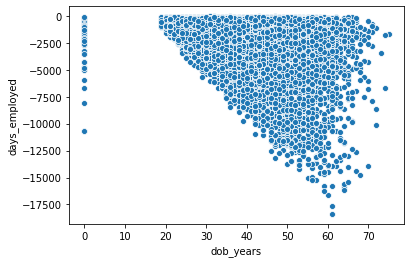

In [6]:
seaborn.scatterplot(data=data[ data['days_employed']<0 ], x='dob_years', y='days_employed');

Для отрицательных значений следует поменять знак и привести к типу int  
Кроме этого на графике виден артефакт в виде нулевого возраста

---
Положительные значения в основном определены для старшей возрастной категории:

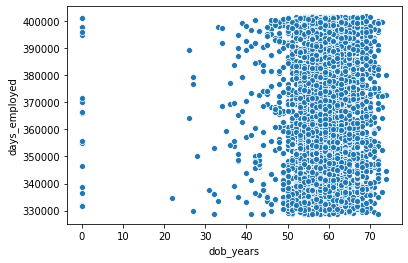

In [7]:
seaborn.scatterplot(data=data[ data['days_employed']>0 ], x='dob_years', y='days_employed');

Проверим тип занятости для этой группы:

In [8]:
data[ data['days_employed']>0 ]['income_type'].value_counts()

пенсионер      3443
безработный       2
Name: income_type, dtype: int64

Соответственно, у кого трудовой стаж указан (отрицательные значения):

In [9]:
data[ data['days_employed']<0 ]['income_type'].value_counts()

сотрудник          10014
компаньон           4577
госслужащий         1312
в декрете              1
предприниматель        1
студент                1
Name: income_type, dtype: int64

___Столбец 'dob_years'___ содержит некорректный возраст 0 лет в 101 строке:

In [10]:
len(data[ data['dob_years']==0 ])

101

остальные данные корректны:

In [11]:
print('Минимальный возраст:', data[ data['dob_years']!=0  ]['dob_years'].min() , 'лет',
      '\nМаксимальный возраст:', data['dob_years'].max(), 'лет' )

Минимальный возраст: 19 лет 
Максимальный возраст: 75 лет


***Столбцы 'education' и 'education_id':***

In [12]:
data.groupby('education_id')['education'].unique()

education_id
0                             [высшее, ВЫСШЕЕ, Высшее]
1                          [среднее, Среднее, СРЕДНЕЕ]
2    [неоконченное высшее, НЕОКОНЧЕННОЕ ВЫСШЕЕ, Нео...
3                    [начальное, НАЧАЛЬНОЕ, Начальное]
4     [Ученая степень, УЧЕНАЯ СТЕПЕНЬ, ученая степень]
Name: education, dtype: object

Текстовое описание имеет по три варианта написания.  

Если привести текстовые описания например в нижний регистр:

In [13]:
data['education'] = data['education'].str.lower()
data.groupby('education_id')['education'].unique()

education_id
0                 [высшее]
1                [среднее]
2    [неоконченное высшее]
3              [начальное]
4         [ученая степень]
Name: education, dtype: object

то каждый 'education_id' будет иметь единственный вариант текстового описания 'education'

---

***Столбцы 'family_status' и 'family_status_id':***

In [14]:
data.groupby('family_status_id')['family_status'].unique()

family_status_id
0          [женат / замужем]
1         [гражданский брак]
2           [вдовец / вдова]
3                [в разводе]
4    [Не женат / не замужем]
Name: family_status, dtype: object

Однозначное соответствие  

---
___Столбец 'gender':___

In [15]:
data['gender'].value_counts()

F      14236
M       7288
XNA        1
Name: gender, dtype: int64

Одно некорректное значение: XNA.  

---
___Столбец 'income_type':___

In [16]:
data['income_type'].value_counts()

сотрудник          11119
компаньон           5085
пенсионер           3856
госслужащий         1459
предприниматель        2
безработный            2
студент                1
в декрете              1
Name: income_type, dtype: int64

___Столбец 'debt':___

In [17]:
data['debt'].value_counts()

0    19784
1     1741
Name: debt, dtype: int64

In [18]:
round(data['debt'].mean(), 4)

0.0809

Важный параметр, по которому можно будет делать выводы.   
Доля клиентов, имевших задолженность по возврату кредита по всем исходным данным составляет **0.0809** 

---
***Столбец 'total_income':***

Посмотрим распределение доходов по источникам:

In [19]:
data.pivot_table(index=['income_type'],
                  values=['total_income'],
                  aggfunc=['count', 'min', 'max', 'mean', 'median']
                  ).astype('int')

,count,min,max,mean,median
,total_income,total_income,total_income,total_income,total_income
income_type,,,,,
безработный,2,59956,202722,131339,131339
в декрете,1,53829,53829,53829,53829
госслужащий,1312,29200,910451,170898,150447
компаньон,4577,28702,2265604,202417,172357
пенсионер,3443,20667,735103,137127,118514
предприниматель,1,499163,499163,499163,499163
сотрудник,10014,21367,1726276,161380,142594
студент,1,98201,98201,98201,98201


Данные имеют очень большой разброс, даже в однотипных группах.  
Стобец содержит пропущенные данные (около 10% от общего числа записей).  
Доля клиентов, имевших задолженность по возврату кредита по записям  
с неуказанным ежемесячным доходом:

In [20]:
round(data[ data['total_income'].isna() ]['debt'].mean(), 4)

0.0782

составляет **0.0782**, что довольно близко к общей доле задолженностей (0.0809)   
Поэтому эти строки целесообразнее удалить из расчетов.

___Столбец 'purpose':___

In [21]:
data['purpose'].value_counts()

свадьба                                   797
на проведение свадьбы                     777
сыграть свадьбу                           774
операции с недвижимостью                  676
покупка коммерческой недвижимости         664
операции с жильем                         653
покупка жилья для сдачи                   653
операции с коммерческой недвижимостью     651
покупка жилья                             647
жилье                                     647
покупка жилья для семьи                   641
строительство собственной недвижимости    635
недвижимость                              634
операции со своей недвижимостью           630
строительство жилой недвижимости          626
покупка недвижимости                      624
покупка своего жилья                      620
строительство недвижимости                620
ремонт жилью                              612
покупка жилой недвижимости                607
на покупку своего автомобиля              505
заняться высшим образованием      

Содержит 38 вариантов целей кредита.   
Требуется лемматизация и объединение в более крупные группы.

**Вывод**  

Для целей исследования важны:  
- семейное положение - исходные данные корректны
- количество детей - некорректных значений 123
- уровень дохода - пропущенных значений 2174
- цели кредита - исходные данные корректны
- наличие задолженности - исходные данные корректны  




## Шаг 2. Предобработка данных

### Обработка пропусков

Удалим строки с некорректными сведениями о количестве детей:

In [22]:
print('Строк до удаления:',len(data))

drop_rows = data[ data['children']==-1 ].index
data = data.drop( drop_rows ).reset_index(drop=True) # удалим строки с некорректными данными

drop_rows = data[ data['children']==20 ].index
data = data.drop( drop_rows ).reset_index(drop=True) # удалим строки с некорректными данными

print('Строк после удаления:',len(data))

Строк до удаления: 21525
Строк после удаления: 21402


Расчитаем медиану дохода для каждой группы 'income_type'.  
Функция fillna_with_my_method обрабатывает строки с пропусками:  
- пропущенный доход заменяется на медиану в соответствующей группе
- пропущенный стаж заполнен нулями, поскольку в данном исследовании  
этот столбец не используется. Кроме того, это позволит легко  
идентифицировать измененные строки. Если бы эти значения использовались,  
можно было бы записать туда например половину возможного стажа: (возраст - 18)*365 /2



In [23]:
income_type_median = data.groupby('income_type')['total_income'].median()

def fillna_with_my_method(row):
    global income_type_median
    if not row.hasnans:
        return row
    row['total_income'] = income_type_median[row['income_type']]
    row['days_employed'] = 0
    return row
    
data = data.apply(fillna_with_my_method, axis=1)
#data.info()

~~Удалим строки с отсутствующими данными:~~ не осталось

In [24]:
data = data.dropna().reset_index(drop=True)
#data.info()

Доля клиентов, имевших задолженность по возврату кредита составляет **0.0809**:

In [25]:
round(data['debt'].mean(), 4)

0.0809

**Вывод**

### Замена типа данных

Заменим вещественные числа на целочисленные:

In [26]:
data['days_employed']=data['days_employed'].astype('int')
data['total_income']=data['total_income'].astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21402 entries, 0 to 21401
Data columns (total 12 columns):
children            21402 non-null int64
days_employed       21402 non-null int64
dob_years           21402 non-null int64
education           21402 non-null object
education_id        21402 non-null int64
family_status       21402 non-null object
family_status_id    21402 non-null int64
gender              21402 non-null object
income_type         21402 non-null object
debt                21402 non-null int64
total_income        21402 non-null int64
purpose             21402 non-null object
dtypes: int64(7), object(5)
memory usage: 2.0+ MB


**Вывод**

### Обработка дубликатов

~~Дубликаты не обнаружены:~~  Удалим 71 строку, являющуюся дублем:

In [27]:
print('Строк до удаления дубликатов:',len(data))
data = data.drop_duplicates().reset_index(drop=True)
print('Строк после удаления дубликатов:',len(data))
#data.info()

Строк до удаления дубликатов: 21402
Строк после удаления дубликатов: 21331


**Вывод**

### Лемматизация

Сгруппируем цели кредита в ключи словаря,  
в качестве значений словаря выделим леммы:

In [28]:
m = Mystem()
purpose_dict = dict.fromkeys(data['purpose'], ())  
for key in purpose_dict:
    print('*', end='')     # be patient ;)
    lst = []
    lemmas = m.lemmatize(key)
    for lemma in lemmas:
        if len(lemma) < 3: # леммы короче 3 символов
            continue       # пропускаем (пробелы, предлоги, знаки препинания)
        lst.append(lemma)
    purpose_dict[key] = lst

**************************************

Добавим столбец со списками лемм в исходную таблицу:

In [29]:
def get_lemmas(str):
    global purpose_dict
    return purpose_dict[str]
data['purpose_lemmas']=data['purpose'].apply(get_lemmas)
data[['purpose','purpose_lemmas']]

,purpose,purpose_lemmas
0,покупка жилья,"[покупка, жилье]"
1,приобретение автомобиля,"[приобретение, автомобиль]"
2,покупка жилья,"[покупка, жилье]"
3,дополнительное образование,"[дополнительный, образование]"
4,сыграть свадьбу,"[сыграть, свадьба]"
...,...,...
21326,операции с жильем,"[операция, жилье]"
21327,сделка с автомобилем,"[сделка, автомобиль]"
21328,недвижимость,[недвижимость]
21329,на покупку своего автомобиля,"[покупка, свой, автомобиль]"


Посчитаем частоту употребления лемм:

In [30]:
lemmas_list = []
for lemmas in data['purpose_lemmas']:
    for lemma in lemmas:
        lemmas_list.append(lemma)
Counter(lemmas_list).most_common()

[('недвижимость', 6314),
 ('покупка', 5865),
 ('жилье', 4437),
 ('автомобиль', 4279),
 ('образование', 3988),
 ('операция', 2587),
 ('свадьба', 2313),
 ('свой', 2219),
 ('строительство', 1867),
 ('высокий', 1367),
 ('получение', 1309),
 ('коммерческий', 1303),
 ('для', 1286),
 ('жилой', 1222),
 ('сделка', 936),
 ('заниматься', 904),
 ('дополнительный', 899),
 ('проведение', 763),
 ('сыграть', 760),
 ('сдача', 649),
 ('семья', 637),
 ('собственный', 628),
 ('ремонт', 604),
 ('подержанный', 481),
 ('подержать', 471),
 ('приобретение', 459),
 ('профильный', 432)]

Наиболее часто используются леммы,   
обозначающие понятия, которые можно приобрести или оплатить:  
***'недвижимость', 'жилье', 'автомобиль',  'образование',  'свадьба',***  
(***'операция'*** в данном контексте означает действие: покупку, а не цель кредита)

**Вывод**

### Категоризация данных

По наличию детей:
- детей нет
- дети есть  
  
_выделять отдельно по количеству детей нецелесообразно,_  
_т.к. получатся очень небольшие группы_

---
По семейному положению:
- состоит в браке
- гражданский брак
- не состоит в браке  

_не состоит в браке объединяет разведенных,_  
_не женатых/не замужем и вдовых_

---
По уровню дохода:
- низкий доход
- средний доход
- высокий доход  

_разделить всех клиентов на три равные по количеству группы,_  
_и таким образом определить границы уровней дохода_

---
По цели кредита
- образование
- свадьба
- автомобиль
- жилье
- недвижимость  


---

Функции для категоризации:

In [31]:
def children_group(children): # данные из столбца 'children'
    if children == 0:
        return 'детей нет'
    return 'дети есть'

def family_group(family_status_id):# данные из столбца 'family_status_id'
    if family_status_id == 0:      # официальный брак
        return 'состоит в браке'
    if family_status_id == 1:       # гражданский брак
        return 'гражданский брак'
    return 'не состоит в браке' # разведен(а), вдова(ец), не женат/не замужем

def purpose_group(purpose_lemmas): # данные из столбца 'purpose_lemmas'
    if 'образование' in purpose_lemmas:
        return 'образование'
    elif 'свадьба' in purpose_lemmas:
        return 'свадьба'
    elif 'автомобиль' in purpose_lemmas:
        return 'автомобиль'
    elif 'недвижимость' in purpose_lemmas:
        return 'недвижимость'
    elif 'жилье' in purpose_lemmas:
        return 'жилье'
    else:
        return 'не определена'

# расчитаем границы разделения по доходу:
tmp = list(data['total_income']) # разделим всех клиентов на три равные по количеству группы
tmp.sort()
low_income = tmp[len(tmp)//3]    # 1/3 клиентов имеют доход ниже этого значения
high_income = tmp[len(tmp)*2//3] # 1/3 клиентов имеют доход выше этого значения

def income_group(total_income): # данные из столбца 'total_income'
    global low_income
    global high_income
    if total_income > high_income:
        return 'высокий доход'
    if total_income < low_income:
        return 'низкий доход'
    return 'средний доход'

Добавим категории в исходную таблицу:

In [32]:
data['children_group'] = data['children'].apply(children_group)
data['family_group'] = data['family_status_id'].apply(family_group)
data['purpose_group'] = data['purpose_lemmas'].apply(purpose_group)
data['income_group'] = data['total_income'].apply(income_group)
data

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_lemmas,children_group,family_group,purpose_group,income_group
0,1,-8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,"[покупка, жилье]",дети есть,состоит в браке,жилье,высокий доход
1,1,-4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,"[приобретение, автомобиль]",дети есть,состоит в браке,автомобиль,низкий доход
2,0,-5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,"[покупка, жилье]",детей нет,состоит в браке,жилье,средний доход
3,3,-4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,"[дополнительный, образование]",дети есть,состоит в браке,образование,высокий доход
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,"[сыграть, свадьба]",детей нет,гражданский брак,свадьба,средний доход
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21326,1,-4529,43,среднее,1,гражданский брак,1,F,компаньон,0,224791,операции с жильем,"[операция, жилье]",дети есть,гражданский брак,жилье,высокий доход
21327,0,343937,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999,сделка с автомобилем,"[сделка, автомобиль]",детей нет,состоит в браке,автомобиль,средний доход
21328,1,-2113,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672,недвижимость,[недвижимость],дети есть,гражданский брак,недвижимость,низкий доход
21329,3,-3112,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093,на покупку своего автомобиля,"[покупка, свой, автомобиль]",дети есть,состоит в браке,автомобиль,высокий доход


**Вывод**

Данные для исследования надежности заемщиков подготовлены.

---

## Шаг 3. Ответьте на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [33]:
data.pivot_table(index=['children_group'],
                  values=['debt'],
                  aggfunc=['mean', 'count']
                  ).round(4)

,mean,count
,debt,debt
children_group,,
детей нет,0.0754,14091
дети есть,0.0924,7240


**Вывод**

Наличие детей увеличивает вероятность задолженности по кредиту  
на ~~24.7%~~ 22.5% по сравнению с клиентами без детей.

---

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [34]:
data.pivot_table(index=['family_group'],
                  values=['debt'],
                  aggfunc=['mean', 'count']
                  ).round(4)

,mean,count
,debt,debt
family_group,,
гражданский брак,0.0931,4134
не состоит в браке,0.0851,4936
состоит в браке,0.0756,12261


**Вывод**

Наиболее надежными являются клиенты, состоящие в браке.  
Для клиентов, состоящих в гражданском браке  
вероятность невозврата кредита в срок выше на ~~18.7%~~ 23.1%   
а для не состоящих в браке на ~~13.4%~~ 12.6% по сравнению с первой группой.

---

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [35]:
data.pivot_table(index=['income_group'],
                  values=['debt'],
                  aggfunc=['mean', 'count']
                  ).round(4)

,mean,count
,debt,debt
income_group,,
высокий доход,0.0752,6968
низкий доход,0.0816,7110
средний доход,0.0866,7253


**Вывод**

Наиболее надежны заемщики с высоким доходом.  
Далее следуют клиенты с низким доходом (риск невозврата выше на ~~9.4%~~ 8.5%),   
хуже всего результат у заемщиков со средним доходом: ~~16.7%~~ 15.2% выше, чем у первой группы.

---

- Как разные цели кредита влияют на его возврат в срок?

In [36]:
data.pivot_table(index=['purpose_group'],
                  values=['debt'],
                  aggfunc=['mean', 'count']
                  ).round(4)

,mean,count
,debt,debt
purpose_group,,
автомобиль,0.0935,4279
жилье,0.0694,4437
недвижимость,0.0748,6314
образование,0.0925,3988
свадьба,0.0791,2313


**Вывод**

Наимененьший риск невозврата имеют кредиты на:
- жилье 
- свадьба (~~+5.7%~~ +14.0%)
- недвижимость (~~+8.0%~~ +7.8%)  

Наибольший риск невозврата:

- образование (~~+31.5%~~ +33.3%)
- автомобиль (~~+34.0%~~ +34.7%)

---

## Шаг 4. Общий вывод

Произведено исследование надежности заемщиков на основании статистики  
о платежеспособности клиентов, предоставленной кредитным отделом банка.  

Столбцы, не представляющие интереса для целей исследования не изменялись:    
поскольку данные не содержат однозначных идентификаторов клиентов, то  
данные в этих столбцах помогают идентифицировать уникальных клиентов  
и найти дубликаты строк (после удаления строк с некорректными и отсутствующими  
данными - таковых не оказалось)  

Около 10% строк не содержат информацию о стаже и ежемесячном доходе.  
Ежемесячный доход необходим в целях исследования, но его величина имеет  
очень большой разброс, и заполнение средними или медианными значениями  
может исказить результат исследования (по крайней мере в части влияния размера  
дохода на возврат кредита). Поэтому эти строки были удалены из обрабатываемых  
данных. Так же были удалены строки с некорректным количеством детей, поскольку  
таких строк было не много.

Категоризация выполнена учетом того, чтобы в группах получились статистически  
значимые выборки имеющие схожие (одного порядка) размеры.  


### Итоговая таблица:
| Категория | Доля задолженности | После заполнения пропусков
|----|:----|:----|
|___Наличие детей:___|  |  |
|детей нет| 0.0749 | 0.0754 |
|дети есть| 0.0934 | 0.0924 |
|___Семейное положение:___|  |  |
|состоит в браке| 0.0761 | 0.0756 |
|не состоит в браке| 0.0863 | 0.0851 |
|гражданский брак| 0.0903 | 0.0931 |
|___Уровень дохода:___|  |  |
|высокий доход| 0.0747 | 0.0752 |
|низкий доход| 0.0817 | 0.0816 |
|средний доход| 0.0872 | 0.0866 |
|___Цель кредита:___|  |  |
|жилье| 0.0702 | 0.0694 |
|свадьба| 0.0742 | 0.0791 |
|недвижимость| 0.0758 | 0.0748 |
|образование| 0.0923 | 0.0925 |
|автомобиль| 0.0940 | 0.0935 |
|___Средняя доля задолженности___|  |  |
|___по всем данным:___| 0.0812 | 0.0812 |


